<a href="https://colab.research.google.com/github/Surojit-KB/UNIV-AI-ML2-HW2/blob/main/Copy_of_Hw2_Part3_distribute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-2: Trees, Model Interrogation and Bayesian Workflow
# Homework 2: Rossman Kaggle: Forecasting Sales
# Part 3 : Extracting embeddings!
**ML-2 Cohort 1** <br>
**Instructor: Dr. Rahul Dave**<br>
**Max Score: 100** <br>

In [1]:
#importing libraries
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

We will repeat the first initial steps again from Part 2

Lets import the feature_train_data.pickle file and set X,y values from the pickle file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open("/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML2/HW/feature_train_data.pickle", 'rb') as f:
    (X,y) = pickle.load(f)

In [4]:
# we will split the train_ratio and 90% and 10% and set the train_size
train_ratio = 0.9
num_records = len(X)
train_size = int(train_ratio * num_records)

In [5]:
#lets look at our data
X[1], y[1]

(array([1058,    0,    0,    0,    1,    0,    0,    1]), '4491')

The next set of inputs is following: 

1. Do you want to one hot encode the data?
2. Do you want to provide embeddings as input - this will be set to **True** for models with entity embeddings
3. Do you want to save the emmbeddings? - again set to **true** if you want to entity embeddings
4. if 3 is set to **true**, we want to save them to a embeddings.pickle


In [6]:
#your code here
one_hot_as_input = False #one_hot is set to True
embeddings_as_input = True 
save_embeddings = True
saved_embeddings_fname = "embeddings.pickle" 

Split the data based on the train_size - same as part 2 

In [7]:
#your code here
X_train=X[:train_size,:]
X_val=X[train_size:,:]
y_train=y[:train_size]
y_val=y[train_size:]

In [8]:
def sample(X, y, n):
  #your code here
    '''random samples'''
    num_row = X.shape[0]
    indices = np.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

In [9]:
X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
X_val, y_val = sample(X_val, y_val, 200000)  # Simulate data sparsity

## Now lets work with Models with Entity embedding!!

To read about Entity Embeddings in more detail and its use cases look at the follwing links:
1. [Enhancing categorical features with Entity Embeddings](https://towardsdatascience.com/enhancing-categorical-features-with-entity-embeddings-e6850a5e34ff)
2. [Understanding Entity Embeddings and It’s Application](https://towardsdatascience.com/understanding-entity-embeddings-and-its-application-69e37ae1501d#:~:text=Loosely%20speaking%2C%20entity%20embedding%20is,a%20sentence%2C%20or%20a%20paragraph.)

The basic outline of this model will be something like this:


![Outline.jpeg](https://drive.google.com/uc?export=view&id=1cm-jylknGEFg9KjehhRy90INkUJqRwrL)

We will be creating the following embeddings:

1. input_store - with input shape as (1,) 
  * The input_store will be passed to output_store to create an embedding layer with embedding shape as 1115, 10
  * we will reshape this to target_shape=(10,)
2. input_dow - with input shape as (1,) 
  * The input_dow will be passed to output_dow to create an embedding layer with embedding shape as 7, 6
  * we will reshape this to target_shape=(6,)
3. input_promo - with input shape as (1,) 
  * output promo will be a dense(1) for input_promo
4. input_year - with input shape as (1,) 
  * The input_year will be passed to output_year to create an embedding layer with embedding shape as 3, 2
  * we will reshape this to target_shape=(2,)
5. input_month - with input shape as (1,) 
  * The input_month will be passed to output_month to create an embedding layer with embedding shape as 12, 6
  * we will reshape this to target_shape=(6,)
6. input_day - with input shape as (1,) 
  * The input_day will be passed to output_day to create an embedding layer with embedding shape as 31, 10
  * we will reshape this to target_shape=(10,)
7. input_germanstate - with input shape as (1,) 
  * The input_germanstate will be passed to output_germanstate to create an embedding layer with embedding shape as 12, 6
  * we will reshape this to target_shape=(6,)


* Construct an input model with all the inputs 
* Construct an output embeddings with all the outputs( basically the embeddings) - concatenate this and call it the **output model**

Set the output model with the following parameters:

1. Dense Layer - 1000 neurons, keep the kernel_initializer as uniform, with activaation as relu
2. Dense Layer - 500 neurons, keep the kernel_initializer as uniform, with activaation as relu
3. Final dense layer with 1 neuron, and activation as sigmoid
4. Create a KerasModel called modelNN_emb:

       modelNN_emb = KerasModel(inputs=input_model, outputs=output_model)
4. Compile the model on mean absolute error and optimizer as adam

In [17]:
#Define the embedding NN model
#your code here
input_store=Input(shape=(1,))
output_store=Embedding(1115,10,name='store')(input_store)
output_store=Reshape(target_shape=(10,))(output_store)

input_dow=Input(shape=(1,))
output_dow=Embedding(7,6,name='dow')(input_dow)
output_dow=Reshape(target_shape=(6,))(output_dow)

input_promo=Input(shape=(1,))
output_promo=Dense(1,name='Promo')(input_promo)

input_year=Input(shape=(1,))
output_year=Embedding(3,2,name='year')(input_year)
output_year=Reshape(target_shape=(2,))(output_year)

input_month=Input(shape=(1,))
output_month=Embedding(12,6,name='month')(input_month)
output_month=Reshape(target_shape=(6,))(output_month)

input_day=Input(shape=(1,))
output_day=Embedding(31,10,name='day')(input_day)
output_day=Reshape(target_shape=(10,))(output_day)

input_germanstate=Input(shape=(1,))
output_germanstate=Embedding(12,6,name='state')(input_germanstate)
output_germanstate=Reshape(target_shape=(6,))(output_germanstate)

input_model=[input_store,input_dow,input_promo,input_year,input_month,input_day,input_germanstate]
output_model=[output_store,output_dow,output_promo,output_year,output_month,output_day,output_germanstate]

output_model=Concatenate()(output_model)
output_model=Dense(1000, kernel_initializer="uniform")(output_model)
output_model=Activation('relu')(output_model)
output_model=Dense(500, kernel_initializer="uniform")(output_model)
output_model=Activation('relu')(output_model)
output_model=Dense(1)(output_model)
output_model=Activation('sigmoid')(output_model)

modelNN_emb = KerasModel(inputs=input_model, outputs=output_model)
modelNN_emb.summary()
modelNN_emb.compile(loss='mae',optimizer='adam')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

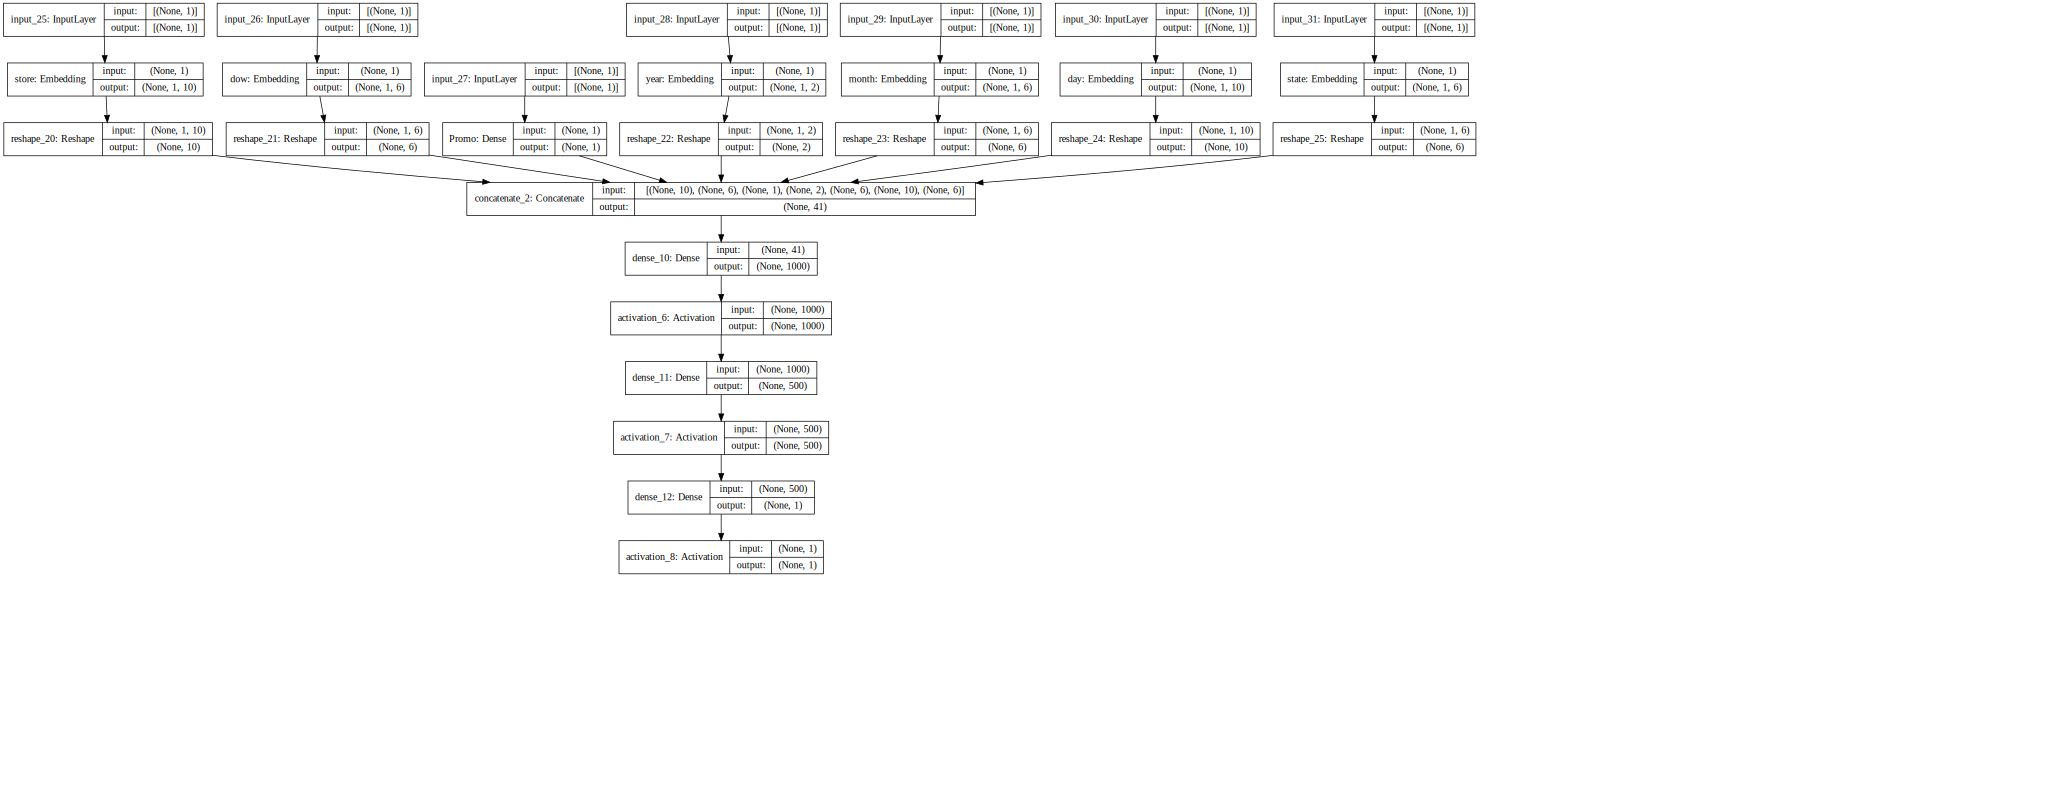

In [22]:
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(modelNN_emb,  show_shapes=True, show_layer_names=True, dpi=52, rankdir='TB').create_svg())

In [25]:
#we will rescale our y_train for the model
#the reason for this is mentioned in the paper in the same section 
max_log_y = max(np.max(np.log(y_train.astype(np.int))), np.max(np.log(y_val.astype(np.int))))
fitting_ytr = np.log(y_train.astype(np.int)) / max_log_y

In [26]:
#do the same for y_val as well
fitting_yval = np.log(y_val.astype(np.int)) / max_log_y

Now that we have built the model, we need to ensure that the input passed to the model is also in the same format - hence we will define a function split the features we are performing embeddings on

In [27]:
X_train[1]

array([139,   0,   7,  16,   4,   0,   0,   8])

In [28]:
#split the features
def split_features(X):
    X_list = []
    #Store index is 0 for me
    store_index = X[..., [0]]
    X_list.append(store_index)

    day_of_week = X[..., [4]]
    X_list.append(day_of_week)

    promo = X[..., [6]]
    X_list.append(promo)

    year = X[..., [1]]
    X_list.append(year)

    month = X[..., [2]]
    X_list.append(month)

    day = X[..., [3]]
    X_list.append(day)

    State = X[..., [7]]
    X_list.append(State)

    return X_list

In [29]:
def preprocessing(X):
    X_list = split_features(X)
    return X_list

1. Add a ModelCheckpoint to save the weights 

2. Fit the model on the `preprocessing(X_train)` and on the fitting_y with 10 epochs and batch_size as 128 
  * add in callback here for ModelCheckPoint and also provide validation data here. 
  * ModelCheckPoint will be used to save the weights for the model, we will use these weights for each embedding layer( you can read more about model check point [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint))

In [31]:
modelNN_emb.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
modelNN_emb.fit(preprocessing(X_train), fitting_ytr, epochs = 10, batch_size = 128, validation_data= (preprocessing(X_val),fitting_yval), callbacks=[modelNN_emb.checkpointer])

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0072 - val_loss: 0.0103

Epoch 00001: val_loss improved from inf to 0.01029, saving model to best_model_weights.hdf5
Epoch 2/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0070 - val_loss: 0.0096

Epoch 00002: val_loss improved from 0.01029 to 0.00960, saving model to best_model_weights.hdf5
Epoch 3/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0069 - val_loss: 0.0095

Epoch 00003: val_loss improved from 0.00960 to 0.00946, saving model to best_model_weights.hdf5
Epoch 4/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0068 - val_loss: 0.0097

Epoch 00004: val_loss did not improve from 0.00946
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0067 - val_loss: 0.0102

Epoch 00005: val_loss did not improve from 0.00946
Epoch 6/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0066 - va

Now we will save the embeddings from the model defined above:
check if save_embeddings is set to True first, if yes store the following:
  1. store_embedding
  2. dow_embedding
  3. year_embedding
  4. month_embedding
  5. day_embedding
  6. state_embedding


Save this entire embeddings into the pickle file - **saved_embeddings_fname - embeddings.pickle**

In [34]:
if save_embeddings:
    store_embedding = modelNN_emb.get_layer('store').get_weights()[0]
    dow_embedding = modelNN_emb.get_layer('dow').get_weights()[0]
    year_embedding = modelNN_emb.get_layer('year').get_weights()[0]
    month_embedding = modelNN_emb.get_layer('month').get_weights()[0]
    day_embedding = modelNN_emb.get_layer('day').get_weights()[0]
    german_states_embedding = modelNN_emb.get_layer('state').get_weights()[0]
    with open(saved_embeddings_fname, 'wb') as f:
        pickle.dump([store_embedding, dow_embedding, year_embedding,
                     month_embedding, day_embedding, german_states_embedding], f, -1)

# You are done with Part 3!! 
Remember to save the embeddings.pickle - this will be used in Part 4!